# Covid19 Exploratory and Predictive Analysis

## 1. Necessary Datasets

In [192]:
import pandas as pd
import numpy as np
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as bs
import html


In [193]:
t_url = 'https://en.wikipedia.org/wiki/Template:2019%E2%80%9320_coronavirus_pandemic_data#covid19-container'
#opening the connection and grabbing the url
u_client = uReq(t_url)
page_html = u_client.read()
u_client.close()

In [194]:
#parsing
page_soup = bs( page_html, "html")
page_table = page_soup.table


C:\Users\DELL\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\DELL\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [220]:
columns = [a.get_text().strip() for a in page_table.find_all("tr")[0].find_all("th")]
columns = np.array(columns)
columns= np.delete(columns,-1)
print(columns)
Covid19_world = pd.DataFrame(columns = columns)

loc, cases, deaths, rec, ref = [a.get_text().strip() for a in page_table.find_all("tr")[1].find_all("th")]

Covid19_world = Covid19_world.append({'Locations[a]':loc, 'Cases[b]': cases, 'Deaths':deaths, 'Recov.[c]':rec},ignore_index=True)


rows = page_table.find_all('tr')[2:-2]
for t in rows:
    b=t.find_all('th')[1]
    loc=b.a.get_text().strip()    
    a= t.find_all('td')[:-1]
    x,y,z= [td.get_text().strip() for td in a ]
    Covid19_world = Covid19_world.append({'Locations[a]':loc,'Cases[b]': x, 'Deaths':y, 'Recov.[c]':z},ignore_index=True)

Covid19_world['Locations[a]']=Covid19_world['Locations[a]'].replace('China (mainland)','China') 
Covid19_world['Locations[a]']=Covid19_world['Locations[a]'].replace('United Kingdom','England') 



Covid19_world.head(20)

['Locations[a]' 'Cases[b]' 'Deaths' 'Recov.[c]']


,Locations[a],Cases[b],Deaths,Recov.[c]
0,181,"585,000","26,827","131,428"
1,United States,"97,090","1,479",816
2,Italy,"86,498","9,134","10,950"
3,China,"81,340","3,292","74,588"
4,Spain,"64,059","4,934","9,357"
5,Germany,"49,436",308,"6,280"
6,France,"32,964","1,995","5,700"
7,Iran,"32,332","2,378","11,133"
8,Switzerland,"12,351",204,897
9,England,"11,660",578,140


In [221]:
import geopandas as gp
from shapely.geometry import point
%matplotlib inline
import bokeh

In [222]:
#Read shapefile using Geopandas
gdf = gp.read_file(r'C:\Users\DELL\Desktop\CoronavirusProject\TM_WORLD_BORDERS-0.3.shp')
worldmap=gdf[['NAME','geometry']]
worldmap.head()

,NAME,geometry
0,Antigua and Barbuda,"MULTIPOLYGON (((-61.68667 17.02444, -61.73806 ..."
1,Algeria,"POLYGON ((2.96361 36.80222, 2.98139 36.80694, ..."
2,Azerbaijan,"MULTIPOLYGON (((45.08332 39.76804, 45.26639 39..."
3,Albania,"POLYGON ((19.43621 41.02107, 19.45055 41.06000..."
4,Armenia,"MULTIPOLYGON (((45.57305 40.63249, 45.52888 40..."


In [223]:
for countries in Covid19_world['Locations[a]'][1:].tolist():
    worldmap_names= worldmap['NAME'].tolist()
    if countries not in worldmap_names:
        print(countries + ' is not in the shp file')

for c in worldmap_names:
    if c not in Covid19_world['Locations[a]'][1:].tolist():
        print(c)

Iran is not in the shp file
England is not in the shp file
South Korea is not in the shp file
Diamond Princess is not in the shp file
North Macedonia is not in the shp file
Moldova is not in the shp file
Vietnam is not in the shp file
Brunei is not in the shp file
Ivory Coast is not in the shp file
Kosovo is not in the shp file
Northern Cyprus is not in the shp file
DR Congo is not in the shp file
Tanzania is not in the shp file
Eswatini is not in the shp file
Laos is not in the shp file
Myanmar is not in the shp file
Syria is not in the shp file
Republic of the Congo is not in the shp file
Vatican City is not in the shp file
East Timor is not in the shp file
Libya is not in the shp file
St. Vincent and the Grenadines is not in the shp file
American Samoa
Bermuda
Burma
Solomon Islands
Brunei Darussalam
Congo
Democratic Republic of the Congo
Burundi
Cayman Islands
Comoros
Cook Islands
French Guiana
Falkland Islands (Malvinas)
Micronesia, Federated States of
French Polynesia
Greenland
Gu

In [232]:
#Covid19_countries=Covid19_world.drop([0,44])

index_name = Covid19_world[Covid19_world['Locations[a]'] == 'Diamond Princess'].index
Covid19_countries=Covid19_world.drop(index_name )
Covid19_countries.drop([0],inplace=True)
Covid19_countries.head()

,Locations[a],Cases[b],Deaths,Recov.[c]
1,United States,"97,090","1,479",816
2,Italy,"86,498","9,134","10,950"
3,China,"81,340","3,292","74,588"
4,Spain,"64,059","4,934","9,357"
5,Germany,"49,436",308,"6,280"


True


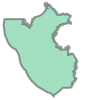

In [233]:
import requests
import json
from shapely import geometry
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon

geometries=[]


url_poly = 'https://nominatim.openstreetmap.org/search.php?q=Peru&polygon_geojson=1&format=geojson'
response=requests.get(url_poly,headers={'User-Agent': 'Chrome'}).json()
poly2=response['features'][1]['geometry']['coordinates']
print(response['features'][0]['geometry']['type']=='Point')
if response['features'][1]['geometry']['type']=='Polygon':
    Polygon=Polygon(response['features'][1]['geometry']['coordinates'][0])
else:
    poly1=[]
    for i in range (0,(len(poly2))):
        for j in poly2[i]:
            poly1.append(Polygon(j))
   
    Polygon=MultiPolygon(poly1)
Polygon

In [234]:
import requests
import json
from shapely import geometry
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon

geometries=[]
Polygons=[]
for country_name in Covid19_countries['Locations[a]'][0:]:
    print(country_name)

    url_poly = 'https://nominatim.openstreetmap.org/search.php?q={}&polygon_geojson=1&format=geojson'.format(country_name)
    response = requests.get(url_poly,headers={'User-Agent': 'Chrome'}).json()
    if response['features'][0]['geometry']['type']=='Point':
        poly2=response['features'][1]['geometry']
    else:
        poly2=response['features'][0]['geometry']

    
    if poly2['type']=='Polygon':
        Polygons.append(Polygon(poly2['coordinates'][0]))
    else:
        poly1=[]

        for i in range (0,(len(poly2['coordinates']))):
            for j in (poly2['coordinates'][i]):
                 poly1.append(Polygon(j))
        Polygons.append(MultiPolygon(poly1))
    
    

print(Polygons)

United States
Italy
China
Spain
Germany
France
Iran
Switzerland
England
South Korea
Netherlands
Austria
Belgium
Turkey
Canada
Portugal
Norway
Australia
Sweden
Israel
Brazil
Czech Republic
Denmark
Malaysia
Ireland
Chile
Luxembourg
Ecuador
Japan
Poland
Pakistan
Romania
South Africa
Thailand
Saudi Arabia
Indonesia
Finland
Russia
Greece
Philippines
Iceland
Singapore
India
Panama
Slovenia
Argentina
Croatia
Mexico
Dominican Republic
Peru
Estonia
Qatar
Serbia
Hong Kong
Egypt
Colombia
Bahrain
Algeria
United Arab Emirates
Lebanon
Iraq
New Zealand
Lithuania
Morocco
Armenia
Hungary
Bulgaria
Latvia
Slovakia
Andorra
Taiwan
Uruguay
Costa Rica
Bosnia and Herzegovina
Tunisia
Kuwait
San Marino
North Macedonia
Ukraine
Jordan
Moldova
Albania
Burkina Faso
Azerbaijan
Vietnam
Cyprus
Malta
Kazakhstan
Ghana
Oman
Senegal
Brunei
Venezuela
Sri Lanka
Cambodia
Ivory Coast
Afghanistan
Belarus
Mauritius
Palestine
Cameroon
Uzbekistan
Georgia
Cuba
Kosovo
Montenegro
Honduras
Trinidad and Tobago
Nigeria
Bolivia
Kyrgyzst

In [242]:
Covid19_countries['geometries']=Polygons
Covid19_countries.head()
Covid19_countries['geometries'].iloc[13]
print(Covid19_countries['geometries'])

1      (POLYGON ((-180 51.7940888, -179.9926876 51.79...
2      (POLYGON ((6.6272658 45.1068023, 6.6272839 45....
3      (POLYGON ((73.4997347 39.3817402, 73.5000261 3...
4      (POLYGON ((-18.3936845 27.7166406, -18.3935045...
5      (POLYGON ((10.4544285 47.5557972, 10.4556876 4...
                             ...                        
178    POLYGON ((-63.051129 17.2791599, -63.0499719 1...
179    (POLYGON ((124.0415703 -9.340033500000001, 124...
180    POLYGON ((9.391081 30.167268, 9.391316 30.1463...
181    (POLYGON ((140.8416553 -6.6106056, 140.8425708...
182    POLYGON ((-61.6657471 12.5966532, -61.3827217 ...
Name: geometries, Length: 181, dtype: object
